In [5]:
import psycopg2
import pandas as pd
import psycopg2.extras
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, normalize

from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import classification_report, confusion_matrix, make_scorer

from sklearn.linear_model import  LinearRegression
from sklearn.svm import SVR
import pickle
 


In [6]:
class PostgresConnection(object):
    def __init__(self):
        self.connection = psycopg2.connect(database="ecomdb",
                                           user = "postgres",
                                           password = "123456",
                                           host = "127.0.0.1",
                                           port = "5432")

    def getConnection(self):
        print("successfully connected to database")
        return self.connection
    
    
# con = PostgresConnection().getConnection()    

### Common Function to fetch Data from all tables 

In [8]:

#  select_stmt= is the SQL select query along with  table and column name    
def retrive_data_from_table(select_stmt): 
    con = PostgresConnection().getConnection()
    cur = con.cursor()
    #select_stmt = select_stmt = "SELECT * FROM :{} ".formate(tablename)
    cur.execute(select_stmt)
    records = cur.fetchall()
    return records


In [9]:
select_stmt = "select t4.item_key, t2.month, t2.year, sum(t1.total_price) "\
              "from ecomdb_star_schema.fact_table t1 "\
              "join ecomdb_star_schema.time_dim t2 on t1.time_key = t2.time_key "\
              "join ecomdb_star_schema.item_dim t4 on t4.item_key = t1.item_key "\
              "group by(t4.item_key, t2.month, t2.year) "\

records = retrive_data_from_table(select_stmt)
df = pd.DataFrame(list(records), columns=['Item', 'Month', 'year', 'Total Sales'])

df

successfully connected to database


,Item,Month,year,Total Sales
0,I00001,1,2014,1518.0
1,I00001,1,2015,3473.0
2,I00001,1,2016,3036.0
3,I00001,1,2017,3438.5
4,I00001,1,2018,3990.5
...,...,...,...,...
22435,I00264,12,2016,3555.0
22436,I00264,12,2017,3465.0
22437,I00264,12,2018,4680.0
22438,I00264,12,2019,3600.0


In [10]:
df['Total Sales'] = df['Total Sales'].astype('int64')
df['Item'] = df['Item'].map(lambda x: x.lstrip('I00').rstrip('aAbBcC'))
df['Item'] = df['Item'].astype('int64')
df

,Item,Month,year,Total Sales
0,1,1,2014,1518
1,1,1,2015,3473
2,1,1,2016,3036
3,1,1,2017,3438
4,1,1,2018,3990
...,...,...,...,...
22435,264,12,2016,3555
22436,264,12,2017,3465
22437,264,12,2018,4680
22438,264,12,2019,3600


#### Save the data frame to file and then reload it again to work with

In [11]:

df.to_pickle('main_data_frame.pkl')    #to save the dataframe, df to 123.pkl
df1 = pd.read_pickle('main_data_frame.pkl') #to load 123.pkl back to the dataframe df
df1

,Item,Month,year,Total Sales
0,1,1,2014,1518
1,1,1,2015,3473
2,1,1,2016,3036
3,1,1,2017,3438
4,1,1,2018,3990
...,...,...,...,...
22435,264,12,2016,3555
22436,264,12,2017,3465
22437,264,12,2018,4680
22438,264,12,2019,3600


###  handle categorical variable  
##### One hot encoding

In [12]:
df2 = df1.copy()
df3 = pd.get_dummies(df2, columns = ['year','Month','Item'])
  
display(df3)

,Total Sales,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,Month_1,...,Item_255,Item_256,Item_257,Item_258,Item_259,Item_260,Item_261,Item_262,Item_263,Item_264
0,1518,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,3473,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3036,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,3438,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,3990,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22435,3555,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
22436,3465,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
22437,4680,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
22438,3600,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [13]:
# x = df3.iloc[:, 1:3].values
y = df3.iloc[:, 0].values
y

array([1518, 3473, 3036, ..., 4680, 3600, 6390], dtype=int64)

In [14]:
x = df3.drop('Total Sales', axis=1)
x

,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,Month_1,Month_2,...,Item_255,Item_256,Item_257,Item_258,Item_259,Item_260,Item_261,Item_262,Item_263,Item_264
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22435,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
22436,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
22437,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
22438,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 10)

In [16]:
LR_model = LinearRegression()
LR_model.fit(x_train,y_train)

LinearRegression()

In [17]:
y_prediction =  LR_model.predict(x_test)
y_prediction

array([6389.5, 4379.5, 5058. , ..., 3993. , 1964. , 4132.5])

In [18]:
# importing r2_score module
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# predicting the accuracy score
score=r2_score(y_test,y_prediction)

print('r2 socre is ',score)
print('mean_sqrd_error is==', mean_squared_error(y_test,y_prediction))
print('root_mean_squared error of is == ', np.sqrt(mean_squared_error(y_test,y_prediction)))

r2 socre is  0.8636809529624384
mean_sqrd_error is== 951173.5436163101
root_mean_squared error of is ==  975.2812638497215


In [19]:
LR_model.score(x_test,y_test)

0.8636809529624384

## Save the model to pickle file

In [20]:
# Save the Modle to file in the current working directory
Pkl_Filename = "Pickle_RL_Model.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(LR_model, file)
    

## Load from pickle for farther operation

In [21]:
# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    Pickled_LR_Model = pickle.load(file)

Pickled_LR_Model  

LinearRegression()

### Try after using StandardScaler

In [22]:
sc = StandardScaler()
X = sc.fit_transform(x)
X

array([[ 2.46644143, -0.40544243, -0.40544243, ..., -0.06166264,
        -0.06166264, -0.06166264],
       [-0.40544243,  2.46644143, -0.40544243, ..., -0.06166264,
        -0.06166264, -0.06166264],
       [-0.40544243, -0.40544243,  2.46644143, ..., -0.06166264,
        -0.06166264, -0.06166264],
       ...,
       [-0.40544243, -0.40544243, -0.40544243, ..., -0.06166264,
        -0.06166264, 16.21727474],
       [-0.40544243, -0.40544243, -0.40544243, ..., -0.06166264,
        -0.06166264, 16.21727474],
       [-0.40544243, -0.40544243, -0.40544243, ..., -0.06166264,
        -0.06166264, 16.21727474]])

In [23]:
y_reshape = y.reshape(-1,1)
Y = sc.fit_transform(y_reshape)
Y
 

array([[-1.25789012],
       [-0.48431538],
       [-0.65723208],
       ...,
       [-0.00671706],
       [-0.4340627 ],
       [ 0.66991354]])

In [24]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 10)

In [25]:
LR_model1 = LinearRegression()
LR_model1.fit(x_train,y_train)

LinearRegression()

In [26]:
y_predict =  LR_model1.predict(x_test)
y_predict = sc.inverse_transform(y_predict)
y_predict

array([[6352.56809924],
       [4386.19196454],
       [5043.79731881],
       ...,
       [3992.08378882],
       [1972.66501266],
       [4146.29500161]])

#### So we can see prediction after and before standard scaler remains same

In [27]:
LR_model1.score(x_test,y_test)

0.8638215196616112

### plotting

In [27]:
x_res = x_train.reshape(-1,1)
print(x_res.shape)
y_res = y_train.reshape(-1,1)
print(y_res.shape)

# plt.scatter(x_res, y_res, s=5, color="blue")
# plt.scatter(x_train, y_train, s=5, color="blue")
# plt.show()

(5098368, 1)
(17952, 1)


In [28]:
x = np.array(x).reshape(-1,1)
y_reshape = y.reshape(-1,1)

# plt.scatter(x, y, s=5, color="blue")
# plt.show()

## Implement SVR

In [28]:
df3

,Total Sales,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,Month_1,...,Item_255,Item_256,Item_257,Item_258,Item_259,Item_260,Item_261,Item_262,Item_263,Item_264
0,1518,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,3473,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3036,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,3438,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,3990,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22435,3555,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
22436,3465,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
22437,4680,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
22438,3600,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [29]:
y = df3.iloc[:, 0]
# y['Total Sales'] = df3['Total Sales']
y

0        1518
1        3473
2        3036
3        3438
4        3990
         ... 
22435    3555
22436    3465
22437    4680
22438    3600
22439    6390
Name: Total Sales, Length: 22440, dtype: int64

In [30]:
x = df3.drop('Total Sales', axis=1)
x.head()

,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,Month_1,Month_2,...,Item_255,Item_256,Item_257,Item_258,Item_259,Item_260,Item_261,Item_262,Item_263,Item_264
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
sc = StandardScaler()
X = sc.fit_transform(x)
X

array([[ 2.46644143, -0.40544243, -0.40544243, ..., -0.06166264,
        -0.06166264, -0.06166264],
       [-0.40544243,  2.46644143, -0.40544243, ..., -0.06166264,
        -0.06166264, -0.06166264],
       [-0.40544243, -0.40544243,  2.46644143, ..., -0.06166264,
        -0.06166264, -0.06166264],
       ...,
       [-0.40544243, -0.40544243, -0.40544243, ..., -0.06166264,
        -0.06166264, 16.21727474],
       [-0.40544243, -0.40544243, -0.40544243, ..., -0.06166264,
        -0.06166264, 16.21727474],
       [-0.40544243, -0.40544243, -0.40544243, ..., -0.06166264,
        -0.06166264, 16.21727474]])

In [32]:
# y_reshape = y.reshape(-1,1)
# Y = sc.fit_transform(y.values.reshape(-1,1))
# Y

Y = sc.fit_transform(pd.DataFrame(y))
Y

array([[-1.25789012],
       [-0.48431538],
       [-0.65723208],
       ...,
       [-0.00671706],
       [-0.4340627 ],
       [ 0.66991354]])

In [33]:
# An 'rbf' (default kernel), 'linear', 'poly', and 'sigmoid' can be used.
model_SVR = SVR(kernel = 'rbf')
model_SVR.fit(X, Y.ravel())

SVR()

In [34]:
y_pred = model_SVR.predict(X)
y_pred = sc.inverse_transform(y_pred) 
y_pred

array([2466.10116605, 3234.74013663, 2980.21207292, ..., 4121.89568732,
       3920.48763034, 4341.0233398 ])

In [35]:
score = model_SVR.score(X, Y.ravel())

print("R-squared:", score)  
print("MSE:", mean_squared_error(y, y_pred))
print("RMSE:", np.sqrt(np.abs(score)))



R-squared: 0.8801840149007659
MSE: 765250.6745866364
RMSE: 0.938181227109542


# Try  SVR param tuning with GridSearchCV

In [36]:
param_grid={
         'kernel': ['rbf'],
         'C': [1, 10, 100, 1000, 10000],
         'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9],
#        'epsilon': [0.0003, 0.007, 0.0109, 0.019, 0.14, 0.05, 8, 0.2, 3, 2, 7],
        }
# scoring='neg_mean_squared_error' What it mean
scorer = make_scorer(mean_squared_error, greater_is_better=False)
svr_grid = GridSearchCV(SVR(epsilon = 0.01), param_grid, cv = 10, scoring=scorer,verbose=0, n_jobs=-1)


In [ ]:
grid_result = svr_grid.fit(X, Y.ravel())
print(grid_result)

In [ ]:
y_rbf = svr_grid.fit(X, y).predict(X)
#print the best parameters from all possible combinations
print("best parameters are: ", svr_grid.best_params_)

In [ ]:
# Checking the score for all parameters
print("Grid scores on training set:")

means = svr_grid.cv_results_['mean_test_score']  
stds = svr_grid.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, svr_grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))

In [ ]:
# Plotting
plt.figure(1)
plt.plot(X, y, '--r', label = 'Original Curve')
plt.plot(X, y_rbf, c = 'navy', label = 'gcv_Predicted')
plt.legend()

In [ ]:
# Try with best parameter
SVR_model_vest_param = SVR(epsilon = 0.01, C= 1, gamma= 0.5, kernel= 'rbf')

y_rbf = svr_grid.fit(X, y).predict(X)

# grid_result = svr_grid.fit(X, y)

print("Mean squared error: %.2f" % mean_squared_error(y, y_rbf))



C:\Users\Windows 10\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


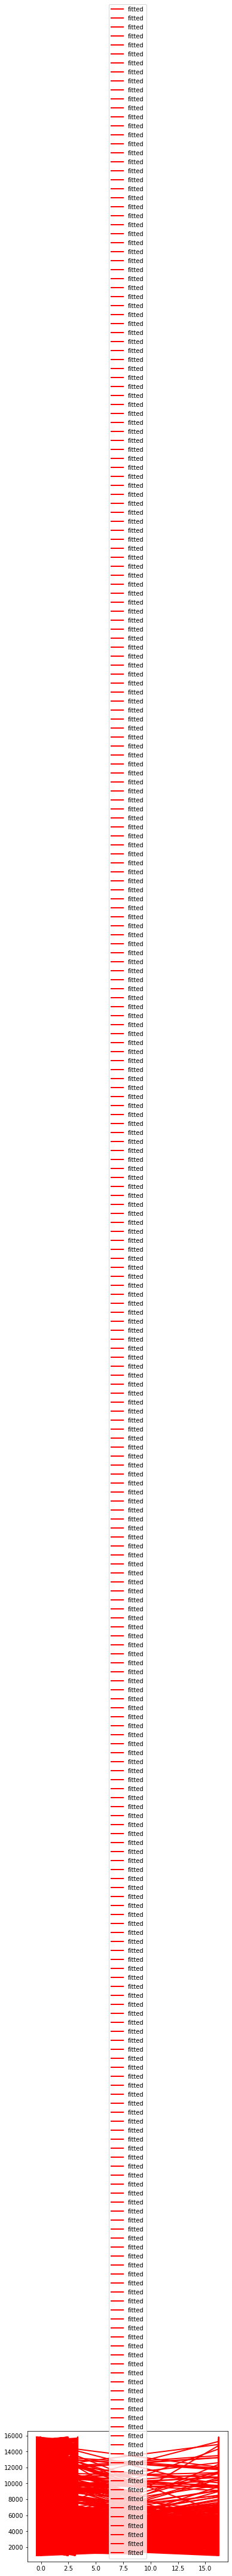

In [80]:
# plt.scatter(X, Y, s=5, color="blue", label="original")
plt.plot(X, y_pred, lw=2, color="red", label="fitted")
plt.legend()
plt.show()

In [52]:
# plt.scatter(X, Y.ravel(), s=5, color="blue", label="original")
# plt.plot(X, y_pred, lw=2, color="red", label="fitted")
# plt.legend()
# plt.show()

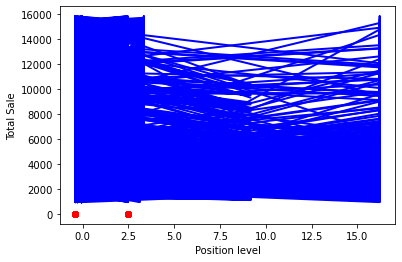

In [267]:
# Visualising the SVR results 
plt.plot(X, y_pred, lw=2, color = 'blue') 
plt.scatter(y_test y_predict, color = 'red') 
plt.xlabel('Position level') 
plt.ylabel('Total Sale') 
plt.show()

In [ ]:
X_grid = np.arange(min(X), max(X), 0.01) #this step required because data is feature scaled.
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X, y, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.title('Truth or Bluff (SVR)')
plt.xlabel('Position level')
plt.ylabel('Salary')
plt.show()

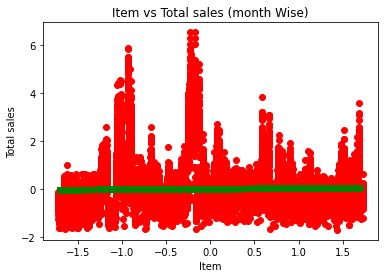

In [163]:
#Visualization of the training set results
plt.scatter(X_train[:,0], y_train, color = 'red')
plt.plot(X_train, model_regressor.predict(X_train), color = 'green')
plt.title('Item vs Total sales (month Wise)')
plt.xlabel('Item')
plt.ylabel('Total sales')
plt.show()

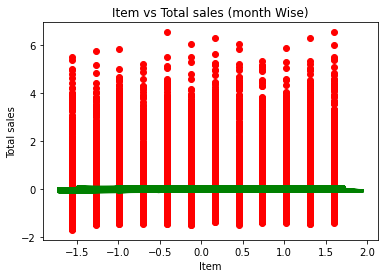

In [161]:
#Visualization of the training set results
plt.scatter(X_train[:,1], y_train, color = 'red')
plt.plot(X_train, model_regressor.predict(X_train), color = 'green')
plt.title('Item vs Total sales (month Wise)')
plt.xlabel('Item')
plt.ylabel('Total sales')
plt.show()


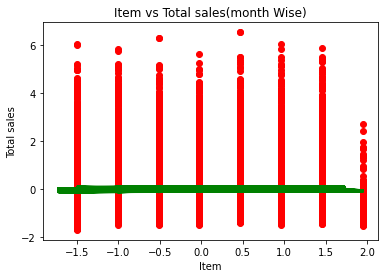

In [162]:
#Visualization of the training set results
plt.scatter(X_train[:,2], y_train, color = 'red')
plt.plot(X_train, model_regressor.predict(X_train), color = 'green')
plt.title('Item vs Total sales(month Wise)')
plt.xlabel('Item')
plt.ylabel('Total sales')
plt.show()

## SVR Example 

(1000, 1)
(1000,)


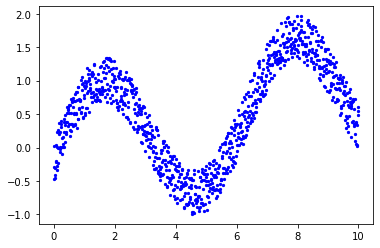

In [30]:
np.random.seed(21)

N = 1000    
def makeData(x):    
    r = [a/10 for a in x]
    y = np.sin(x)+np.random.uniform(-.5, .2, len(x))
    return np.array(y+r)

x = [i/100 for i in range(N)]
y = makeData(x)
x = np.array(x).reshape(-1,1)

print(x.shape)
print(y.shape)

plt.scatter(x, y, s=5, color="blue")
plt.show()

In [33]:
svr = SVR().fit(x, y)
print(svr)

SVR()


In [34]:
yfit = svr.predict(x)

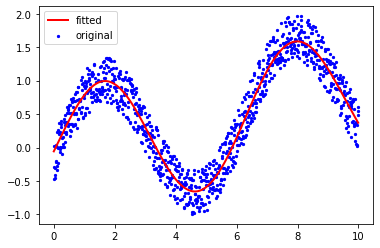

In [35]:
plt.scatter(x, y, s=5, color="blue", label="original")
plt.plot(x, yfit, lw=2, color="red", label="fitted")
plt.legend()
plt.show()